In [1]:
from astropy import units as u
from astropy import constants as const
from astropy.time import Time

from poliastro.util import norm
from poliastro.frames import Planes
from poliastro.ephem import Ephem
from poliastro.bodies import Earth

from poliastro.twobody.orbit import Orbit
from poliastro.twobody.sampling import EpochsArray

from astropy.coordinates import solar_system_ephemeris

import numpy as np
import sys
sys.path.append('../')

from sim.stations import dss25, dss34
from sim.tracking import Tracking
from sim.util import describe_orbit, describe_state, describe_trajectory

solar_system_ephemeris.set("de440")
goldstone_end = Tracking.NEAR_GOLDSTONE_END.value
canberra_start = Tracking.NEAR_CANBERRA_START.value

In [2]:
sampling_interval = 180
sample_offsets = np.arange(0, (canberra_start-goldstone_end)/(1*u.s), sampling_interval)
flyby_epochs = goldstone_end + (sample_offsets << u.s)
print("Start and end epochs:", goldstone_end, flyby_epochs[-1], "[", flyby_epochs.size, "]")

Start and end epochs: 1998-01-23 06:14:55.600 1998-01-23 09:53:55.600 [ 74 ]


In [3]:
near_goldstone_end_rv = Ephem.from_horizons("NEAR", goldstone_end, attractor=Earth, plane=Planes.EARTH_EQUATOR).rv(goldstone_end)
describe_state(near_goldstone_end_rv, dss25, goldstone_end)

near_goldstone_orbit = Orbit.from_vectors(Earth, near_goldstone_end_rv[0], near_goldstone_end_rv[1], goldstone_end)
describe_orbit(near_goldstone_orbit)


:AT: 1998-01-23 06:14:55.600
Geocentric distance: 37471.700215992445 km speed: 8.258344936971223 km / s
From Goldstone-25 : range  31576.174442159892 km , range rate  -7.684513660227914 km / s

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.97266698121356 deg
Eccentricity: 1.813357091534396
Semilatus rectum: 19437.250829758486 km
Semimajor axix: -8494.322039490264 km
Periapse radius: 6908.917068596319 km , altitude: 530.7804685963192 km


In [4]:
near_goldstone_ephem = near_goldstone_orbit.to_ephem(EpochsArray(flyby_epochs))
describe_trajectory(near_goldstone_ephem, dss34)


::TRAJECTORY::
Start and end ranges: 37309.07130107391 km 73145.82143191747 km
Start and end radial speeds: -7.97119272554438 km / s 7.3216176182785535 km / s
Closest: 11326.436162795784 km speed 12.740147538216107 km / s  at  1998-01-23 07:23:55.600
Deflection: 64.92614895100142 deg


In [5]:
ref_data = []
meas_data = []
for o in sample_offsets:
    e = goldstone_end + o*u.s
    ref_r, ref_rr, ref_ra = dss25.range_rate_accel(near_goldstone_ephem.rv(e), e)
    ref_data.append(ref_rr)
    meas_data.append(ref_rr - ref_ra*ref_r/const.c)

print(ref_data)
print(meas_data)

[<Quantity -7.68451366 km / s>, <Quantity -7.68859907 km / s>, <Quantity -7.6904411 km / s>, <Quantity -7.68921684 km / s>, <Quantity -7.68382247 km / s>, <Quantity -7.67276512 km / s>, <Quantity -7.65400721 km / s>, <Quantity -7.6247393 km / s>, <Quantity -7.58104499 km / s>, <Quantity -7.51740151 km / s>, <Quantity -7.4259295 km / s>, <Quantity -7.29526419 km / s>, <Quantity -7.1088708 km / s>, <Quantity -6.84260482 km / s>, <Quantity -6.46143802 km / s>, <Quantity -5.91587967 km / s>, <Quantity -5.14051095 km / s>, <Quantity -4.06131765 km / s>, <Quantity -2.62385755 km / s>, <Quantity -0.84897196 km / s>, <Quantity 1.11354362 km / s>, <Quantity 3.00243583 km / s>, <Quantity 4.55222568 km / s>, <Quantity 5.61905466 km / s>, <Quantity 6.2490598 km / s>, <Quantity 6.60996749 km / s>, <Quantity 6.84455502 km / s>, <Quantity 7.02001572 km / s>, <Quantity 7.15918724 km / s>, <Quantity 7.27008394 km / s>, <Quantity 7.35729432 km / s>, <Quantity 7.42473613 km / s>, <Quantity 7.47597901 km 

In [6]:
from lmfit import Parameters, minimize, fit_report

fit_params = Parameters()
fit_params.add('a', min=-8600e3, max=-8200e3, value=near_goldstone_orbit.a.to_value(u.m))
fit_params.add('inc', min=0, max=np.pi, value=near_goldstone_orbit.inc.to_value(u.rad))
fit_params.add('ecc', min=1.7, max=1.9, value=near_goldstone_orbit.ecc.to_value(u.one))
fit_params.add('nu', min=-np.pi, max=np.pi, value=near_goldstone_orbit.nu.to_value(u.rad))
fit_params.add('raan', min=0, max=2*np.pi, value=near_goldstone_orbit.raan.to_value(u.rad))
fit_params.add('argp', min=0, max=2*np.pi, value=near_goldstone_orbit.argp.to_value(u.rad))

def residual(pars, offsets, data):
    vals = pars.valuesdict()
    print(vals)
    orbit = Orbit.from_classical(attractor=Earth,
                                 a=vals['a']*u.m,
                                 ecc=vals['ecc']*u.one,
                                 inc=vals['inc']*u.rad,
                                 raan=vals['raan']*u.rad,
                                 argp=vals['argp']*u.rad,
                                 nu=vals['nu']*u.rad,
                                 epoch=goldstone_end,
                                 plane=Planes.EARTH_EQUATOR)
    ephem = orbit.to_ephem(EpochsArray(flyby_epochs))
    rres = []
    for i, v in enumerate(offsets):
        e = goldstone_end + v*u.s
        meas_rr = data[i]
        model_r, model_rr = dss25.range_and_rate(ephem.rv(e), e)
        rres.append((model_rr - meas_rr).to_value(u.m/u.s))
    return rres

In [7]:
out = minimize(residual, fit_params, args=(sample_offsets,), kws={'data': meas_data})
print(fit_report(out))

{'a': -8494322.039490264, 'inc': 1.884478540981543, 'ecc': 1.813357091534396, 'nu': -1.8394247601999354, 'raan': 1.540059254992049, 'argp': 2.533258385194789}
{'a': -8494322.039490264, 'inc': 1.884478540981543, 'ecc': 1.813357091534396, 'nu': -1.8394247601999354, 'raan': 1.540059254992049, 'argp': 2.533258385194789}
{'a': -8494322.039490264, 'inc': 1.884478540981543, 'ecc': 1.813357091534396, 'nu': -1.8394247601999354, 'raan': 1.540059254992049, 'argp': 2.533258385194789}
{'a': -8494322.038199617, 'inc': 1.884478540981543, 'ecc': 1.813357091534396, 'nu': -1.8394247601999354, 'raan': 1.540059254992049, 'argp': 2.533258385194789}
{'a': -8494322.039490264, 'inc': 1.884478545592624, 'ecc': 1.813357091534396, 'nu': -1.8394247601999354, 'raan': 1.540059254992049, 'argp': 2.533258385194789}
{'a': -8494322.039490264, 'inc': 1.884478540981543, 'ecc': 1.81335709173224, 'nu': -1.8394247601999354, 'raan': 1.540059254992049, 'argp': 2.533258385194789}
{'a': -8494322.039490264, 'inc': 1.884478540981

In [8]:
print(out.residual)

[ 0.01932164  0.01678764  0.01411104  0.01128445  0.00830283  0.00516543
  0.00187897 -0.00153719 -0.00504283 -0.00856379 -0.01197128 -0.0150501
 -0.01745244 -0.01863885 -0.01782849 -0.01404115 -0.00644881  0.00458535
  0.01570959  0.01984141  0.01061572 -0.00849939 -0.02187778 -0.01617198
  0.0008794   0.01163836  0.0118712   0.00688697  0.00125878 -0.00316554
 -0.0060677  -0.00767481 -0.00832241 -0.00830857 -0.00786211 -0.00714805
 -0.00628163 -0.00534177 -0.00438174 -0.00343691 -0.0025303  -0.00167647
 -0.00088416 -0.00015817  0.00049939  0.00108818  0.00160906  0.00206363
  0.00245396  0.00278237  0.00305131  0.00326326  0.00342068  0.00352594
  0.00358135  0.00358906  0.00355116  0.00346957  0.00334614  0.00318258
  0.00298051  0.00274143  0.00246676  0.00215782  0.00181586  0.00144205
  0.00103748  0.00060319  0.00014014 -0.00035074 -0.0008686  -0.00141261
 -0.001982   -0.00257604]


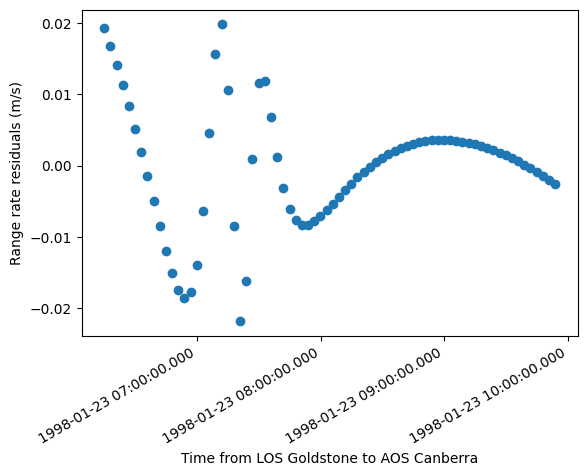

In [9]:
import matplotlib.pyplot as plt
from astropy import visualization
with visualization.time_support():
    plt.xlabel('Time from LOS Goldstone to AOS Canberra')
    plt.ylabel('Range rate residuals (m/s)')
    plt.scatter(flyby_epochs, out.residual)
    plt.gcf().autofmt_xdate()